On this seminar your are asked to implement simple community detection algorithm. It is called [Markov Cluster Algorithm](http://micans.org/mcl/) (MCL).

Implement Markov Clustering Algorithm

**Input:** Transition matrix $T = D^{-1}A$

**Output:** Adjacency matrix $M^*$

1. Set $M = T$
2. **repeat:**
    3. *Expansion Step:* $M = M^p$ (usually $p=2$)
    4. *Inflation Step:* Raise every entry of $M$ to the power $\alpha$ (usually $\alpha=2$)
    5. *Renormalize:* Normalize each row by its sum
    6. *Pruning:* Replace entries that are close to $0$ by pure $0$
7. **until** $M$ converges
8. $M^* = M$

As a result you should get a cluster matrix s.t. elements of the cluster correspont to nonzero elements of the columns of the matrix. 
<br\>
* Run this method for network [1](https://www.hse.ru/data/2016/03/15/1127695811/network1.mat), [2](https://www.hse.ru/data/2016/03/15/1127699956/network2.mat) and [3](https://www.hse.ru/data/2016/03/15/1127703057/network3.mat).
* Play with the parameters ($p$, $\alpha$, zero tolerance), analyse the results

<hr />


Few important libraries to import:

In [2]:
import os
import urllib
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import networkx as nx

plt.style.use("ggplot")
%matplotlib inline

Firstly, let's define MCL function:

In [3]:
def MCL(A, tol, p, alpha):
    step = 1
    col_sums = A.sum(axis = 0)
    T = A / col_sums[np.newaxis, :]
    M = T
    while(1):
        #print ('step ', step)
        step += 1
        # Expancion step:
        M1 = np.linalg.matrix_power(M, p)
        # Inflation step:
        M1 = np.power(M1, alpha)
        col_sums = M1.sum(axis = 0)
        M1 = M1 / col_sums[np.newaxis, :]
        M1[M1<=tol] = 0
        if np.linalg.norm(M - M1) == 0:
            return M1
        else:
            M = M1.copy()

In [7]:
urls = ["https://dl.dropboxusercontent.com/s/bsovg2zqx9hq39b/network1.mat?dl=1",
        "https://dl.dropboxusercontent.com/s/kcfv2ts6xu6xzpf/network2.mat?dl=1",
        "https://dl.dropboxusercontent.com/s/19xd7kjy2tm15ms/network3.mat?dl=1"]
for i in range(1,4):
    with urllib.request.urlopen(urls[i-1]) as f:
        data = f.read()
    with open(f'network{i}.mat', 'bw') as f:
        f.write(data) 

Let's take several networks and make use of the MCL function. Firstly, plot adjacency matrices for each network:

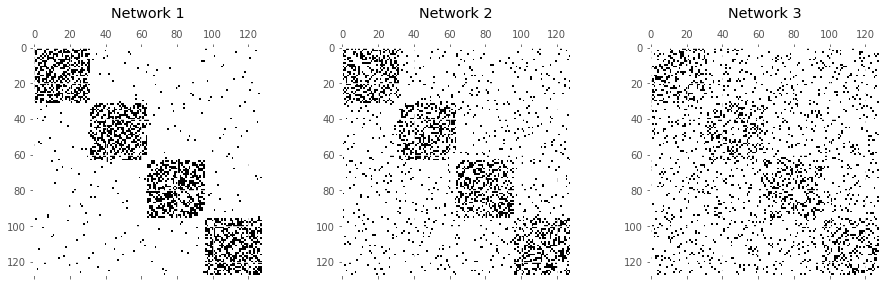

In [8]:
files = ["network1.mat", "network2.mat", "network3.mat"]

plt.figure(figsize = (13, 4))
for file in files:
    plt.subplot(1, 3, files.index(file) + 1)
    data = scipy.io.loadmat(file)
    A = data['A'].astype('float')
    plt.spy(A)
    plt.title("Network " + str(files.index(file) + 1), y = 1.1)
plt.tight_layout()

The networks have the same number of nodes, however the connections patterns are different. The "concentration" of nodes diminishes from the 1st to the last network. But still, 4 clusters can be seen from any of pictures above.

Let's have a look at how the can be drawn with networkx:

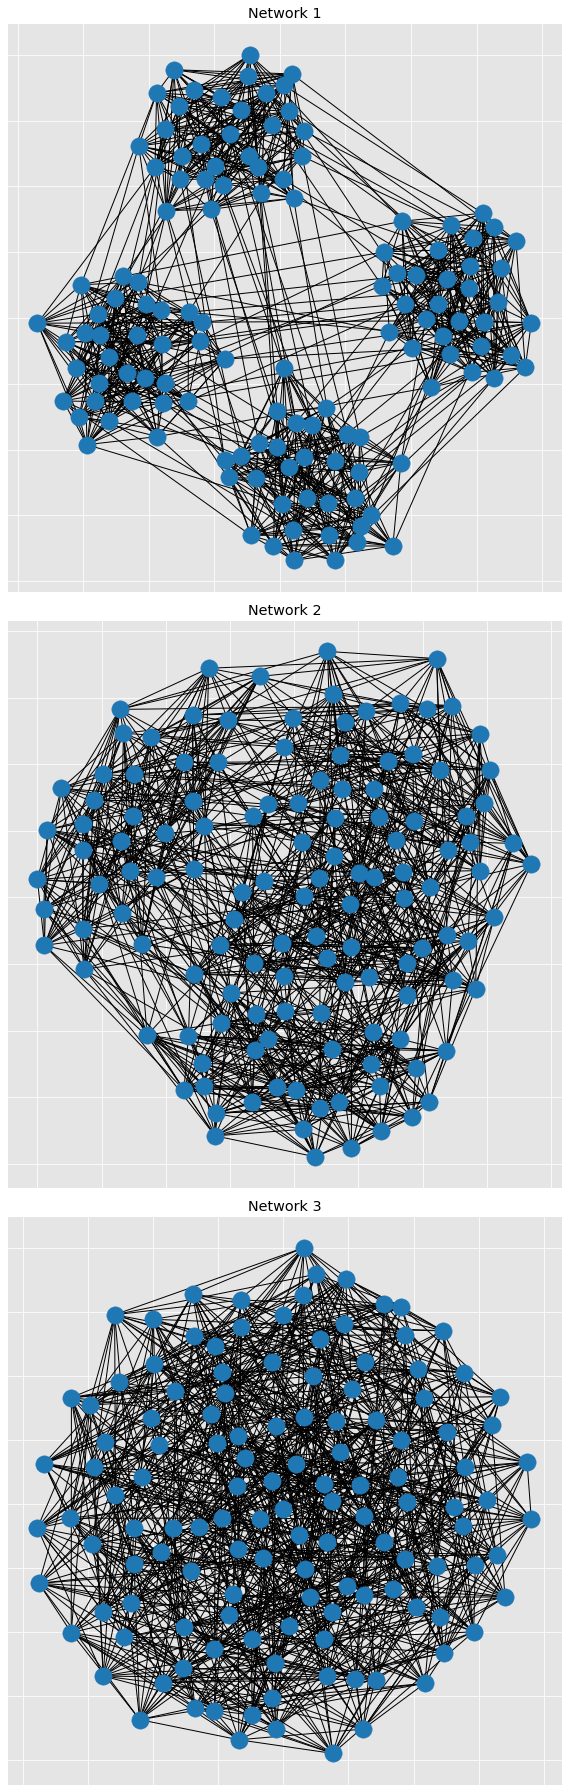

In [25]:
plt.figure(figsize = (8, 25))
for file in files:
    plt.subplot(3, 1, files.index(file) + 1)
    data = scipy.io.loadmat(file)
    A = data['A'].astype('float')
    G = nx.Graph(A)
    nx.draw_networkx(G, with_labels = False)
    plt.title("Network " + str(files.index(file) + 1))
plt.tight_layout()

There are 4 distinctive clusters in the 1st network, probably several clusters in the 2nd network. The last network seems to have many messy random connections, but let's see how the MCL algorithm with recommended parameters can recognize the clusters, if there are any.

Start with Network #1:

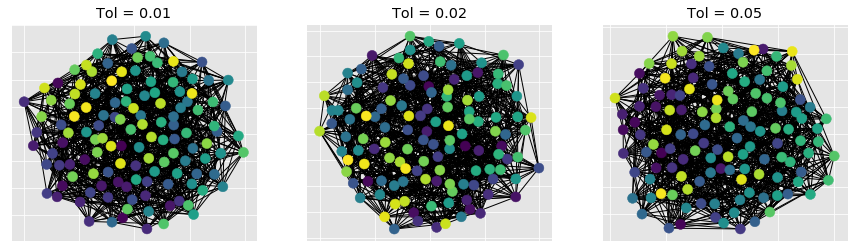

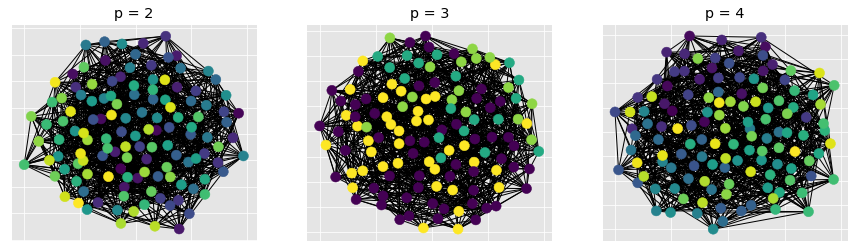

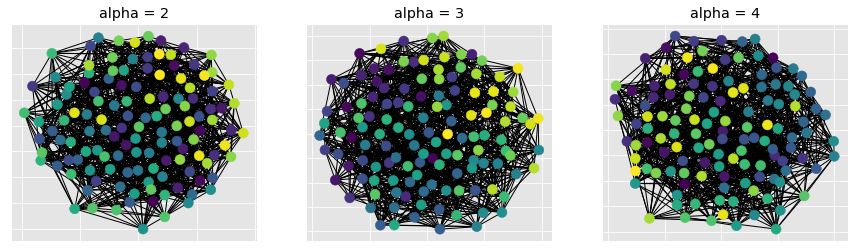

In [11]:
data = scipy.io.loadmat(files[2])
A = data['A'].astype('float')
tol = [0.01, 0.02, 0.05]
p_values = [2, 3, 4]
alpha = [2, 3, 4]

G = nx.Graph(A)
plt.figure(figsize=(15, 4))
for t in tol:
    M1 = MCL(A, tol = t, p = 2, alpha = 2)
    cluster_num = []
    for i in range(M1.shape[0]):
        cluster_num.append(np.ix_(M1[:, i] == 1)[0][0])    
    plt.subplot(1, 3, 1 + tol.index(t))
    nx.draw_networkx(G, with_labels = False, node_size=100, node_color=cluster_num)
    plt.title("Tol = " + str(t))

plt.figure(figsize=(15, 4))
for p in p_values:
    M1 = MCL(A, tol = 0.02, p = p, alpha = 2)
    cluster_num = []
    for i in range(M1.shape[0]):
        cluster_num.append(np.ix_(M1[:, i] == 1)[0][0])    
    plt.subplot(1, 3, 1 + p_values.index(p))
    nx.draw_networkx(G, with_labels = False, node_size=100, node_color=cluster_num)
    plt.title("p = " + str(p))
    
plt.figure(figsize=(15, 4))
for a in alpha:
    M1 = MCL(A, tol = 0.01, p = 2, alpha = a)
    cluster_num = []
    for i in range(M1.shape[0]):
        cluster_num.append(np.ix_(M1[:, i] == 1)[0][0])    
    plt.subplot(1, 3, 1 + alpha.index(a))
    nx.draw_networkx(G, with_labels = False, node_size=100, node_color=cluster_num)
    plt.title("alpha = " + str(a))

**With defalut parameters (alpha = 2, p = 2, tol = 0.01) the MCL algorithm can succesfully recognize 4 clusters in Network 1.**

* Tolerance and alpha parameters play the similar role - increasing them, the elements of matrix M also inflate, and consequently, more nodes are considered to be clusters. 
* Parameter p oppositely allows to diminish the elements of matrix M and the therefore the number of clusters shortens.

Now it's time to apply MCL algorithm (changing only parameter p) to the other 2 networks, where clusters are vague: 

127
4
128
4


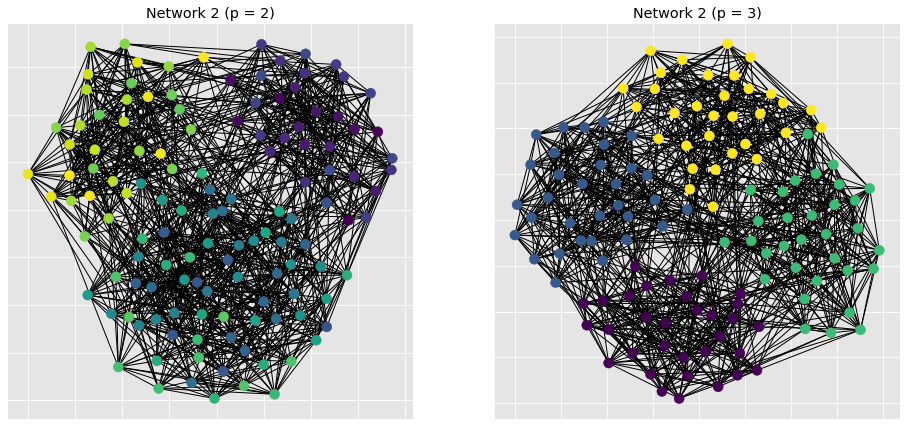

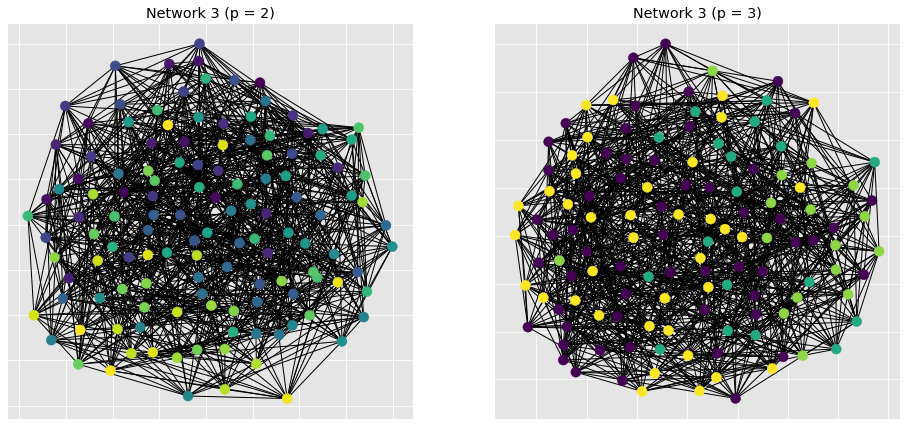

In [14]:
for file in files[1:]:
    data = scipy.io.loadmat(file)
    A = data['A'].astype('float')
    G = nx.Graph(A)
    plt.figure(figsize=(16, 16))
    p_values = [2, 3]
    ind = 1
    for p in p_values:
        M1 = MCL(A, tol = 0.02, p = p, alpha = 2)
        cluster_num = []
        for i in range(M1.shape[0]):
            cluster_num.append(np.ix_(M1[:, i] == 1)[0][0])
        print(len(set(cluster_num)))
        plt.subplot(2, 2, ind)
        nx.draw_networkx(G, with_labels = False, node_size=100, node_color=cluster_num)
        plt.title("Network " + str(files.index(file) + 1) + " (p = " + str(p) + ")")
        ind += 1

**The algorithm is able to find 4 clusters in network #2  and #3 with parameter p = 3 (tol = 0.02 and alpha = 2)**

Yahoo Music network

Edges in this network appear if enough number of users have given ratings to both music bands. Note, that edges are weighted with similarity of the ratings.

You can load .mat files with the following commands:

In [5]:
url = "https://dl.dropboxusercontent.com/s/enmsd002em2s6w1/music_data.mat?dl=1"
with urllib.request.urlopen(url) as f:
    data = f.read()
with open('music_data.mat', 'bw') as f:
    f.write(data) 
    
data = scipy.io.loadmat('music_data.mat')
A = data["A"].astype("float")

The edges are weighted... OK. Let's consider that existence of the edge depends on the treshold value.
There is graph below, which shows how the number of edges depends on that treshold.

Text(0.5, 1.0, 'Yahoo Music network')

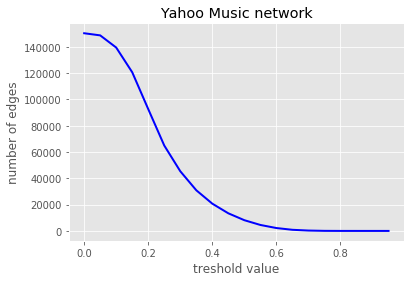

In [8]:
X = np.arange(0, 1, 0.05)
y = np.array([(A > x).sum() / 2 for x in X])

plt.plot(X, y, "b", lw = 2)
plt.ylabel("number of edges")
plt.xlabel("treshold value")
plt.title("Yahoo Music network")

There is no given formulation what is **similarity** of ratings, so I reasonably assume, that the ratings are similar, if the element in matrix A is not less than 0.5

In [18]:
tr = 0.5
A[A < tr] = 0
A[A >= tr] = 1
deg_vec = np.array(A.sum(axis = 1))

/home/alena/repos/sna_edu/venv/lib/python3.6/site-packages/scipy/sparse/compressed.py:287: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/home/alena/repos/sna_edu/venv/lib/python3.6/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [19]:
ind = np.nonzero(deg_vec.ravel())
A = A.tocsc()[ind]
A = A.tocsc()[:, ind[0]]
deg_vec = np.array(A.sum(axis = 1))

D = np.diag(np.array(deg_vec)[:,0])
L = D - A
w, v = np.linalg.eig(L)

Plot a graph of the network:

Text(0.5, 1.0, 'Yahoo Music network')

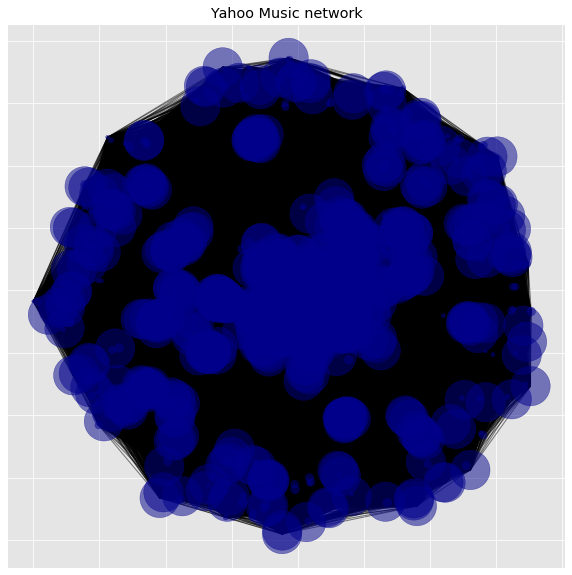

In [21]:
G = nx.Graph(A)
plt.figure(figsize=(10,10))
nx.draw_networkx(G, 
                 with_labels=False, 
                 node_size=[10 * x for x in G.degree()],
                 node_color = "darkblue",
                 alpha = 0.5)
plt.title("Yahoo Music network")

There are many connected components of the graph, in theory their number must depend on how many zero eigenvalues the Laplacian matrix has. 

The number of eigenvalues which equal to zero should be equal to the number of connected components and this is indeed true!

In [12]:
print("Number of zero-valued eigenvalues -", (w < 1e-14).sum())
print("Number of connected components in the graph -", nx.number_connected_components(G))

Number of zero-valued eigenvalues - 132
Number of connected components in the graph - 132


We are interested only in largest connected component of the graph in order to apply algorithm for searching communities.

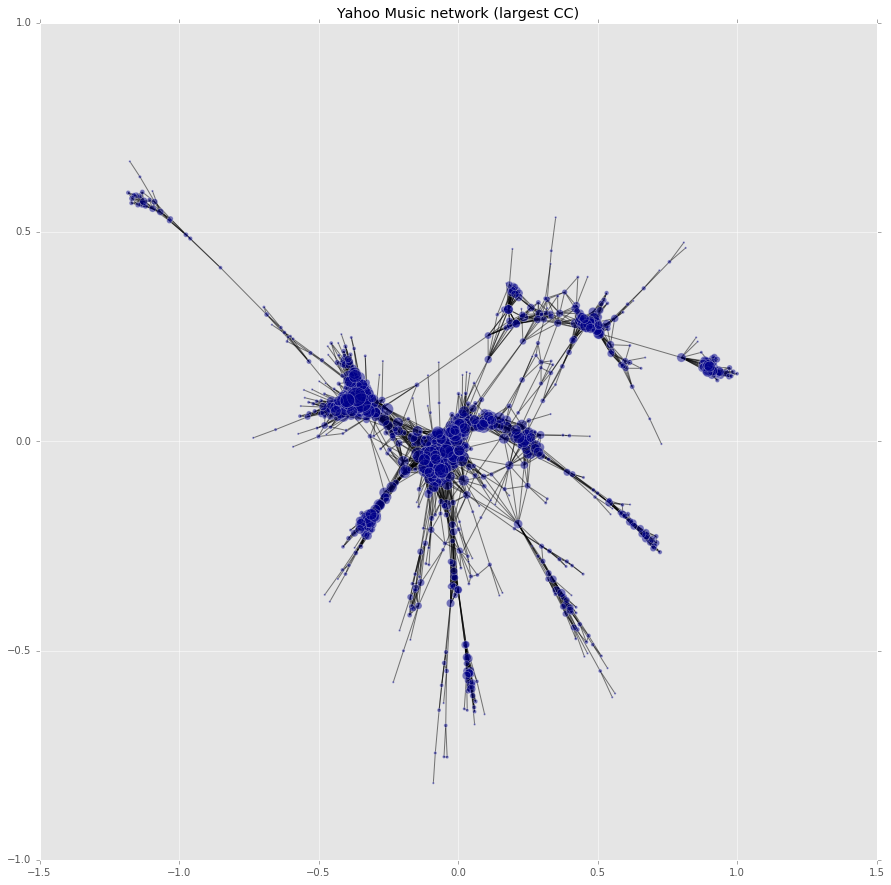

In [27]:
largest_cc = max(nx.connected_components(G), key=len)
ind = np.array(list(largest_cc))
A_cc = A.tocsc()[ind, :]
A_cc = A_cc.tocsc()[:, ind]

G_cc = nx.Graph(A_cc)
coord = nx.spring_layout(G_cc, iterations=100)
plt.figure(figsize=(15,15))
nx.draw_networkx(G_cc,
                 pos = coord,
                 with_labels=False, 
                 node_size=[5 * x for x in G_cc.degree().values()],
                 node_color = "darkblue",
                 alpha = 0.5)
plt.title("Yahoo Music network (largest CC)")

Check whether the connected component is single in the graph:

In [14]:
deg_vec = np.array(A_cc.sum(axis = 1))
D = np.diag(np.array(deg_vec)[:,0])
L = D - A_cc
w, v = np.linalg.eig(L)

print("Number of zero-valued eigenvalues -", (w < 1e-14).sum())
print("Number of connected components in the graph -", nx.number_connected_components(G_cc))

Number of zero-valued eigenvalues - 1
Number of connected components in the graph - 1


We are actually need the second smallest eigenvalue and relevant eigenvector for partitioning.

In [15]:
ind_w = np.argsort(w)
w2 = w[ind_w[1]]
v2 = np.array(v[:, ind_w[1]]).ravel()

The partitioning will be realized if for the two consecutive values of sorted 2nd eigenvector the absolute difference is higher than the particular **threshold parameter** and the minimum number of nodes in both partitions is at least **min_nodes parameter**. 

The recursive procedure is used to find partitioning. 

In [16]:
def partitioning(delta, left, right, output, treshold = 0.0005, min_nodes = 30):
    ind_part = np.where(delta >= treshold)[0] 
    if ind_part.shape[0] < 0:
        return    
    elif ind_part.shape[0] >= 1:
        ind = ind_part[0] + left
        length = min(ind - left, right - ind)
        for i in ind_part:
            if min(i - left, right - i) > length:
                ind = i
                length = min(i - left, right - i)
        if length >= min_nodes:
            output.append(ind)
            delta_left = delta[left:ind]
            delta_right = delta[ind:]
            ind_left = partitioning(delta_left, left = 0, right = delta_left.shape[0], output=output)
            ind_right = partitioning(delta_right, left = ind, right = ind + delta_right.shape[0], output=output)
    return sorted(output)

def spectral_community_detection(v2):
    ind_sort = np.argsort(v2)
    delta = np.diff(v2[ind_sort]) / (v2.max() - v2.min())

    cuts = partitioning(delta, left = 0, right = delta.shape[0], output = list())
    cuts.append(0)
    cuts.append(delta.shape[0] + 1)
    cuts.sort()

    communities = []
    for node in cuts[:-1]: 
        community = ind_sort[list(range(node, cuts[cuts.index(node) + 1]))]
        communities.append(list(community))
    nodes_comm = [0] * (v2.shape[0])
    
    for n in range(len(nodes_comm)):
        for comm in communities:
            if n in comm:
                nodes_comm[n] = communities.index(comm) + 1
    
    plt.figure(figsize=(15,15))
    G = nx.Graph(A_cc)
    nx.draw_networkx(G, 
                     with_labels = False,
                     pos = coord,
                     node_size=[5 * x for x in G.degree().values()], 
                     node_color=nodes_comm, 
                     alpha = 0.5)
    plt.title("Communities of Yahoo Music network")

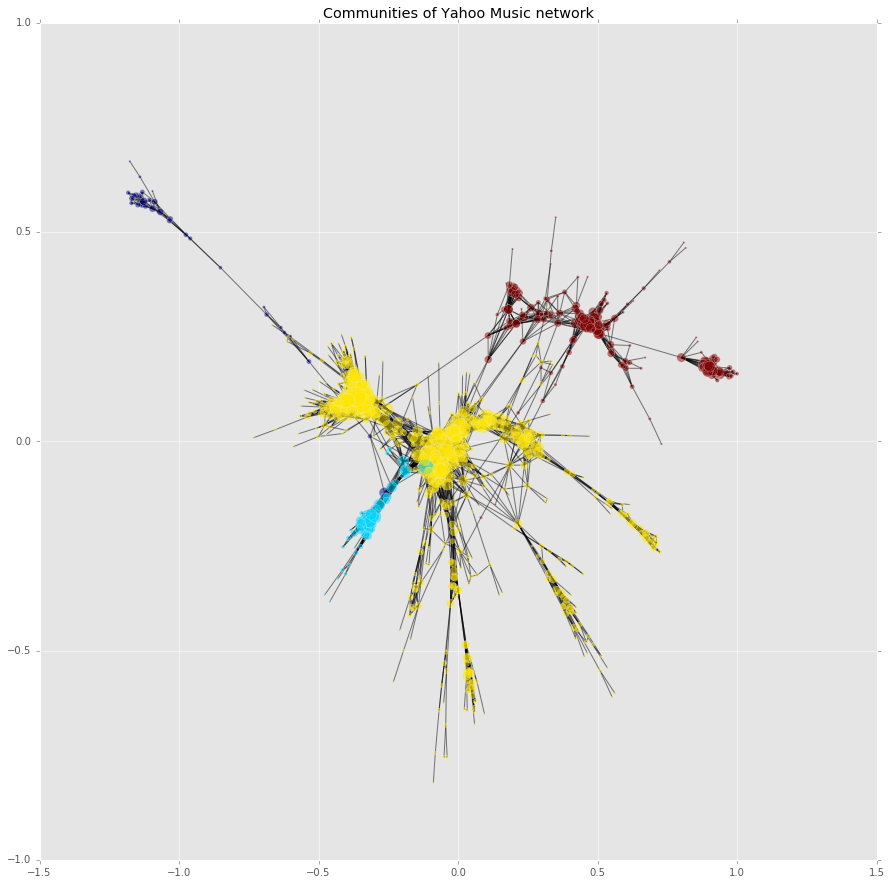

In [28]:
spectral_community_detection(v2)

The visual representation of output proves the correctness of algorithm realization.

With given set of parameters, there are **4 clusters** found in the largest component of the network.

I suppose that these communities are directly connected with the **main music genres**. The yellow - colored community is probably formed by **pop-music** lovers, because it is the largest one.